# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
Контролировать добросовестность кассиров при продаже алкоголя.


**Цель проекта:** построить модель, которая по фотографии определит приблизительный возраст человека.

# Исследовательский анализ данных

## Исследовательский анализ данных

In [ ]:
# Импортируем бибилиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Размер выборки и график распределения

In [ ]:
# Сохраняем датасет
df = pd.read_csv('//datasets/faces//labels.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
display(df.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Наблюдаем, что в датасете 7591 строка, две колонки: название изображения и возраст. Тип данных соответствует данным, пропуски отсутствуют.

Построим график распределения возраста в выборке

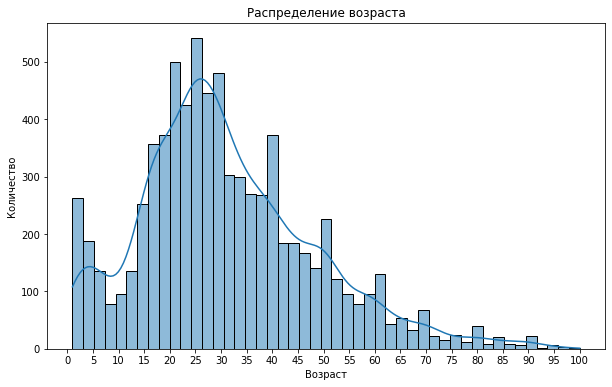

In [ ]:
# Построение графика распределения возраста
plt.figure(figsize=(10, 6))
sns.histplot(df['real_age'], kde=True)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста')
plt.xticks(range(0, max(df['real_age'])+1, 5))
plt.show()

In [ ]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Наблюдаем, что средний возраст составляет 31.2 года, а медианный возраст 29 лет.  
Также, отмечаем наличие пиков, примерно раз в пять лет. Возможно, это связано с методом сбора данных и округления возраста.

### Вывод фотографий

In [ ]:
df['real_age'] = df['real_age'].astype(str)


In [ ]:
datagen = ImageDataGenerator(rescale=1/255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='file_name',
    y_col='real_age',
    directory='/datasets/faces/final_files/',
    target_size=(100, 100),
    batch_size=16,
    class_mode='sparse'
)


features, target = next(datagen_flow)




Found 7591 validated image filenames belonging to 97 classes.


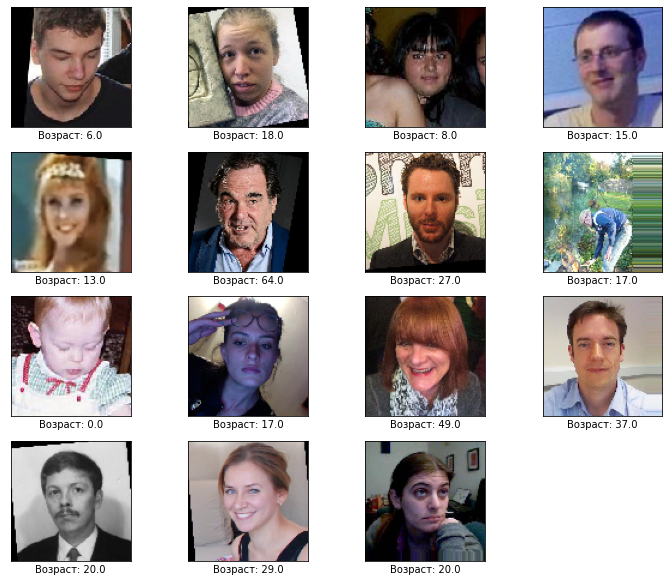

In [ ]:
# выводим 15 изображений с возрастом
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(5, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel('Возраст: ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
print(features.shape)
print(target.shape)

(16, 100, 100, 3)
(16,)


Наблюдаем, что фото - четырёхмерный массив. Фото цветные, 3 канала, размер изображений - 100 * 100.  
Также, отмечаем, что некоторые объекты сдвинуты, некоторым не хватает цвета, а также, разметка фото не всегда соответствует действительности.

### Вывод по разделу

В данном разделе был построен график распределения возраста. Средний возраст составляет 31.2 года, а медианный 29 лет. Обнаружены пики, примерно, каждые 5 лет.  
Были рассмотрены фото, представленные в датасете. Думается, для лучшего обучения необходимо провести аугментации изображений.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       horizontal_flip=True,
                                       validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345,
        subset='training'
    )
    return train_gen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345,
        subset='validation'
    )
    return test_gen_flow



def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
    return model

```

Found 5694 validated image filenames.  
Found 1897 validated image filenames.  
Epoch 1/5  
356/356 - 51s - loss: 201.6196 - mae: 10.2605 - val_loss: 456.2680 - val_mae: 16.1607  
Epoch 2/5  
356/356 - 39s - loss: 82.1685 - mae: 6.9508 - val_loss: 137.7681 - val_mae: 9.1199  
Epoch 3/5  
356/356 - 39s - loss: 58.6619 - mae: 5.8431 - val_loss: 93.2773 - val_mae: 7.2086  
Epoch 4/5  
356/356 - 38s - loss: 44.3219 - mae: 5.0859 - val_loss: 82.5727 - val_mae: 6.9514  
Epoch 5/5  
356/356 - 38s - loss: 33.2538 - mae: 4.4258 - val_loss: 78.2635 - val_mae: 6.8407  
119/119 - 10s - loss: 78.2635 - mae: 6.8407  
Test MAE: 6.8407




## Анализ обученной модели

В данном проекте была проделана работа по построению модели для определения возраста людей.

При обучении была использована архитектура ResNet50 на предобученных весах. Был выбран размер батча 16, оптимизатор Adam, 5 эпох. Заморозка весов не использовалась.

Можно сделать вывод, о том, что с первой задачей, а именно анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы модель справится, т.к. значение МАЕ на тестовой выборке меньше 8.

Касательно второй задачи по контролю добросовестности кассиров при продаже алкоголя, думается, что применять модель нецелесообразно, т.к. отклонение модели для этой задачи существенно. Возможно, если производить отсечку по большему возрасту, тогда модель можно применять.